# 2D Plate, Bayes Optimizer

In [2]:
%load_ext autoreload
%autoreload 2

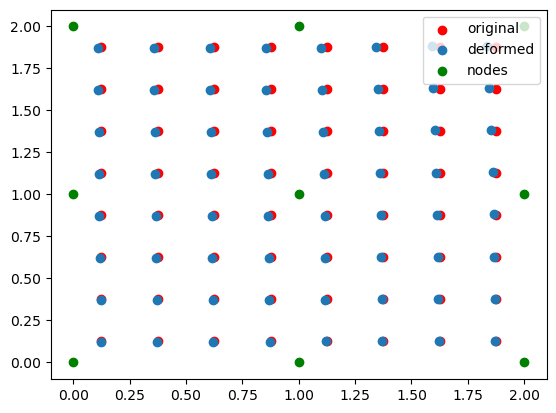

In [5]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from jax import grad, jit, value_and_grad
from tqdm import tqdm
import json
import time

from diffmpm.constraint import Constraint
from diffmpm.element import Quadrilateral4Node
from diffmpm.material import LinearElastic
from diffmpm.mesh import Mesh2D
from diffmpm.particle import Particles
from diffmpm.solver import MPMExplicit
from diffmpm.functions import Linear, Unit
from diffmpm.forces import NodalForce, ParticleTraction
import diffmpm.writers as writers

# output
format = "npz"
folder = "results/"
step_frequency = 1

# material
E_true = 1000
material = LinearElastic({"youngs_modulus": E_true, "poisson_ratio" : 0, "density": 1, "id" : 0})

# particles
with open("particles-2d-uniaxial-stress.json", "r") as f:
    ploc = jnp.asarray(json.load(f))
particles = Particles(ploc, material, jnp.array([0]))

# external forces
fn = Unit(-1)
true_f1 = 0
true_f2 = -10
cnf1 = NodalForce(node_ids=[6], function=fn, dir=0, force=true_f1)
cnf2 = NodalForce(node_ids=[8], function=fn, dir=0, force=true_f2)
pst = []

# element
constraints = [(jnp.array([0]), Constraint(0, 0.0)), (jnp.array([0,1,2]), Constraint(1, 0.0))]
elements = Quadrilateral4Node(
    [2,2], 4, [1, 1], constraints, concentrated_nodal_forces=[cnf1, cnf2]
    )

# mesh
mesh = Mesh2D({
    "particles": [particles], 
    "elements": elements, 
    "particle_surface_traction" : []
    })

# scheme
dt = 0.01
nsteps = 10
mpm = MPMExplicit(
    mesh, 
    dt, 
    scheme="usl", 
    sim_steps=nsteps, 
    out_dir="results/",
    writer_func=writers.NPZWriter().write
    )
true_result = mpm.solve_jit(0)
target_vel = true_result["velocity"]
result = true_result

plt.scatter(orig[:,:,0], orig[:,:,1], color='r', label='original')
plt.scatter(result['loc'][:,0], result['loc'][:,1], label='deformed')
plt.scatter(nodes[:,0], nodes[:,1], color='g', label = 'nodes')
plt.legend()
plt.show()



In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from jax import grad, jit, value_and_grad
from tqdm import tqdm
import json

from diffmpm.constraint import Constraint
from diffmpm.element import Quadrilateral4Node
from diffmpm.material import LinearElastic
from diffmpm.mesh import Mesh2D
from diffmpm.particle import Particles
from diffmpm.solver import MPMExplicit
from diffmpm.functions import Linear, Unit
from diffmpm.forces import NodalForce, ParticleTraction
import diffmpm.writers as writers
import time

# output
format = "npz"
folder = "results/"
step_frequency = 1

# material
E_true = 1000
material = LinearElastic({"youngs_modulus": E_true, "poisson_ratio" : 0, "density": 1, "id" : 0})

# particles
with open("particles-2d-uniaxial-stress.json", "r") as f:
    ploc = jnp.asarray(json.load(f))
particles = Particles(ploc, material, jnp.array([0]))

# external forces
fn = Unit(-1)
true_f1 = 0
true_f2 = -10
cnf1 = NodalForce(node_ids=[6], function=fn, dir=0, force=true_f1)
cnf2 = NodalForce(node_ids=[8], function=fn, dir=0, force=true_f2)
pst = []

# element
constraints = [(jnp.array([0]), Constraint(0, 0.0)), (jnp.array([0,1,2]), Constraint(1, 0.0))]
elements = Quadrilateral4Node(
    [2,2], 4, [1, 1], constraints, concentrated_nodal_forces=[cnf1, cnf2]
    )

# mesh
mesh = Mesh2D({
    "particles": [particles], 
    "elements": elements, 
    "particle_surface_traction" : []
    })

# scheme
dt = 0.01
nsteps = 10
mpm = MPMExplicit(
    mesh, 
    dt, 
    scheme="usl", 
    sim_steps=nsteps, 
    out_dir="results/",
    writer_func=writers.NPZWriter().write
    )
true_result = mpm.solve_jit(0)
target_vel = true_result["velocity"]


from bayes_opt import BayesianOptimization


#loss function for bayesian optimization
@jit
def compute_loss_bayes(E, force_1, force_2, mpm=mpm, target_vel=target_vel):
    mpm.mesh.elements.concentrated_nodal_forces = [
        NodalForce(node_ids=[6], function=fn, dir=0, force=force_1),
        NodalForce(node_ids=[8], function=fn, dir=0, force=force_2)
    ]
    mpm.mesh.particles[0].material.properties["youngs_modulus"] = E

    result = mpm.solve_jit(0)
    vel = result["velocity"]
    loss = jnp.linalg.norm(vel[:, :] - target_vel[:, :])
    return -loss

#giving bound to the value of the youngs_modulus for bayesian optimizer
pbounds = {"E": (900, 1100), 'force_1': (-1, 1), 'force_2': (-11, -9)}
optimizer = BayesianOptimization(
    f=compute_loss_bayes, pbounds=pbounds, random_state=1, verbose=2
)
#measuring the time taken by the optimizer
start_t = time.time()
#calling the optimizer, init_points is the number of random points to be sampled
#n_iter is the number of iterations to be performed
optimizer.maximize(init_points=3, n_iter=500)
end_time = time.time()
print(f"Time taken by Bayesian Optimization: {end_time-start_t}")
print(optimizer.max)
# plt.savefig("../../../FEMSurrogateModelling/2D Plate Figures/output.png")

|   iter    |  target   |     E     |  force_1  |  force_2  |
-------------------------------------------------------------
| 1         | -0.1741   | 983.4     | 0.4406    | -11.0     |
| 2         | -0.3671   | 960.5     | -0.7065   | -10.82    |
| 3         | -0.1249   | 937.3     | -0.3089   | -10.21    |
| 4         | -0.1175   | 938.2     | -0.7636   | -9.326    |
| 5         | -0.1595   | 918.1     | -1.0      | -9.0      |
| 6         | -0.1361   | 1.004e+03 | 0.7116    | -10.26    |
| 7         | -0.2758   | 1.021e+03 | -0.6951   | -10.44    |
| 8         | -0.3823   | 901.5     | 0.8384    | -9.256    |
| 9         | -0.1595   | 994.6     | -1.0      | -9.0      |
| 10        | -0.3308   | 1.1e+03   | 0.9579    | -9.607    |
| 11        | -0.1595   | 1.059e+03 | -1.0      | -9.0      |
| 12        | -0.1595   | 1.046e+03 | 1.0       | -11.0     |
| 13        | -0.1595   | 1.073e+03 | 1.0       | -11.0     |
| 14        | -0.1394   | 927.4     | -0.6929   | -9.072    |
| 15    